In [1]:
 !pip install transformers

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/GPT

!ls

/content/gdrive/MyDrive/GPT
dev_convert_14res.json	summary_2.pth  summary_4.pth  test_convert_14res.json
GPT_cuda_2.ipynb	summary_3.pth  summary.pth    train_convert_14res.json


In [4]:
import json
import pandas as pd
from transformers import AutoTokenizer

In [5]:
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")

pol_dict = {'POS' : [42740,-1], 'NEU' : [5054,-2], 'NEG': [9009,-3]}

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [6]:
#Aspect extraction AE

def load_data(path, tokenizer, polarity_token_dict):
# Abra o arquivo JSON e carregue seu conteúdo
    with open(path, 'r') as arquivo:
        data = json.load(arquivo)

    # Crie uma lista para armazenar as strings de "raw_words". Será input encoder apos tokenização
    total_frases = []

    # Crie uma lista para armazenar os tokens de aspectos, sentimentos e opinioes.
    total_obj = []

    # Crie uma lista para armazenar as posições. Será input loss apos transformar posicao de opinioes.
    total_pos = []

    # Itere sobre os registros no JSON e adicione as strings à lista
    for registro in data:
        # Adiciona frase
        seq = registro['raw_words']
        total_frases.append(seq)

        #Cria lista com posicoes inicial e final de tokens para todas as palavras da frase
        frase_len = 0
        tokens_pos = []
        words = registro['words']

        for wrd in words:
          if len(tokens_pos)>0:
            wrd_tkn = tokenizer(' ' + wrd)['input_ids']
          else:
            wrd_tkn = tokenizer(wrd)['input_ids']

          wrd_len = len(wrd_tkn)-2
          tokens_pos.append([frase_len + 1, frase_len + wrd_len])
          frase_len += wrd_len #Tira token de comecco e fim

        #Obtem tokens e posicoes para aspectos/sentimentos
        aspects = registro['aspects']
        opinions = registro['opinions']

        tkn_list = [0] #lista de tokens, comeca com token de inicio
        pos_list = [] #lista de posicoes

        for i in range(len(aspects)):
          if len(aspects[i]['term'])>0:

            #ASPECTOS
            #Obtem posicoes aspectos
            start_aspect_word_pos = aspects[i].get('from') #posicoes das palavras
            end_aspect_word_pos = aspects[i].get('to')-1

            start_aspect_token_pos = tokens_pos[start_aspect_word_pos][0] #posicoes dos tokens
            end_aspect_token_pos = tokens_pos[end_aspect_word_pos][1]

            #Obtem tokens aspectos
            start_wrd = aspects[i].get('term')[0]
            end_wrd = aspects[i].get('term')[-1]

            if start_aspect_word_pos > 0:     #coloca espacos
              start_aspect_tkn = tokenizer(' ' + start_wrd)['input_ids'][1]
            else:
              start_aspect_tkn = tokenizer(start_wrd)['input_ids'][1]

            if end_aspect_word_pos > 0:     #coloca espacos
              end_aspect_tkn = tokenizer(' ' +end_wrd)['input_ids'][-2]
            else:
              end_aspect_tkn = tokenizer(end_wrd)['input_ids'][-2]



            #Obtem sentimentos
            pol = aspects[i].get('polarity', None)
            pol_tkn = polarity_token_dict.get(pol)[0] #Token de polaridade a partir de dicionario
            pol_pos = polarity_token_dict.get(pol)[1]

            #Adiciona tokens e posicoes

            #Tratar os casos que o aspecto se repete
            if start_aspect_tkn not in tkn_list and end_aspect_tkn not in tkn_list:
                tkn_list.append(start_aspect_tkn)
                tkn_list.append(end_aspect_tkn)
                tkn_list.append(pol_tkn)

                pos_list.append(start_aspect_token_pos)
                pos_list.append(end_aspect_token_pos)
                pos_list.append(pol_pos)

        #Adiciona token de final nas listas
        tkn_list.append(2)
        pos_list.append(frase_len+1)

        #Atualiza listas
        total_obj.append(tkn_list)
        total_pos.append(pos_list)

    return total_frases, total_obj, total_pos



In [7]:
# Especifique o caminho para o arquivo JSON
path_train = 'train_convert_14res.json'

train_frase, train_tkns, train_pos = load_data(path_train,tokenizer,pol_dict)

path_dev = 'dev_convert_14res.json'

dev_frase, dev_tkns, dev_pos = load_data(path_dev,tokenizer,pol_dict)


In [8]:
train_pos[0]

[3, 3, -3, 10]

In [9]:
train_frase[0]

'But the staff was so horrible to us .'

Fazer padding tokens

Tranformacao + pad sequencia

In [10]:
import torch

In [11]:
from torch.utils.data import DataLoader,Dataset
class absadataset(Dataset):
    def __init__(self,frases, tokens , indexes):
        self.frases = [i for i in frases]
        self.tokens = self.token_padding(tokens)
        self.indexes = self.indexes_padding(indexes)
        #self.indexes_mask =
    def __getitem__(self,index):
        return self.frases[index],self.tokens[index],self.indexes[index]#,self.indexes_mask[index]

    def __len__(self):
        return len(self.indexes)

    def token_padding(self, token_list):
        max_tkn_len = max(len(i) for i in token_list)
        tkn = []
        for i in token_list:
          padded = torch.ones(max_tkn_len, dtype = torch.long)
          padded[0:len(i)] = torch.Tensor(i)
          tkn.append(padded.detach().clone())
        return tkn

    def indexes_padding(self, index_list):
        max_idx_len = max(len(i) for i in index_list)
        idxs = []
        for i in index_list:
          #mapa classes
          """
          for j in range(len(i)):
            if i[j]==-1:
              i[j] = max_idx_len + 1
            elif i[j]==-2:
              i[j] = max_idx_len + 2
            elif i[j]==-3:
              i[j] = max_idx_len + 3"""

          padded = torch.zeros(max_idx_len + 1, dtype = torch.long)
          padded[0:len(i)] = torch.LongTensor(i)
          idxs.append(padded.detach().clone())
        return idxs


In [12]:
train_data = absadataset(train_frase, train_tkns, train_pos)
train_datapack = DataLoader(train_data,batch_size=64,shuffle=True)

dev_data = absadataset(dev_frase, dev_tkns, dev_pos)
dev_datapack = DataLoader(dev_data,batch_size=64,shuffle=True)

In [13]:
for a,b,c in train_datapack:
  print(a)
  break

("I had a terrific meal , and our server guided us toward a very nice wine in our price range , instead of allowing us to purchase a similarly priced wine that was n't as good .", 'Pizza here is consistently good .', 'The manager claimed that he could not compensate us for anything on the bill which just shows the lack of sophistication from the entire group .', 'Food was good and the view of the new york city skiline was terrific even on a foggy rainy day like that of when I went .', 'The portions are small but being that the food was so good makes up for that .', 'We thought that this place is using too much of MSG cooking in the foods .', "The place 's decor and hidden bathrooms made for a good laugh .", 'I think the stuff was better than Disney .', 'The food was mediocre at best but it was the horrible service that made me vow never to go back .', 'Pizza - the only pizza in NYC that should not have additional toppings - the crust tastes like the best , freshly baked bread !', 'We f

In [14]:
#import torch
from torch import nn
import transformers
from transformers import AutoTokenizer, BartModel

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##Modelo

###BART

In [16]:
#Modelo BART
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
Bart_M = BartModel.from_pretrained("facebook/bart-base")

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

###Encoder representation transform

In [17]:
#Recebe ultima camada decoder BART, ultima camada encoder BART e input embedding do encoder Bart.
#Transformacao a ser customizada e comparada
#precisa usar mascara para zerar elementos de pad

#linear
"""class Custom_transformation(torch.nn.Module):

    def __init__(self):
        super(Custom_transformation, self).__init__()
        self.lin_weight = nn.Parameter(torch.rand(1))
        self.lin_weight.requires_grad = True

    def forward(self, imp_emb, dec_emb, mask):
        msk = mask.reshape(mask.shape[0],-1,1)

        out = self.lin_weight*dec_emb+(1-self.lin_weight)*imp_emb

        return out*msk"""

#mlp
class Custom_transformation(torch.nn.Module):

    def __init__(self):
        super(Custom_transformation, self).__init__()
        self.lin_weight = nn.Parameter(torch.rand(1))
        self.linear1 = nn.Linear(768, 768,bias=True)
        self.linear2 = nn.Linear(768, 768,bias=True)

    def forward(self, enc_emb, imp_emb, mask):
        x = self.linear1(enc_emb)
        x = torch.nn.functional.relu(x)
        x = self.linear2(x)
        x = torch.nn.functional.relu(x)
        msk = mask.reshape(mask.shape[0],-1,1)

        out = self.lin_weight*x+(1-self.lin_weight)*imp_emb

        return out*msk


In [18]:
tkns_transform = Custom_transformation()

###Insere tokens de classe ao fim dos tokens de input, zera o excedente.

###Completo

In [19]:
#Modelo a ser treinado
#Saida softmax entre indices de input

class ABSAModel(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.bart = Bart_M
        self.dec_transform = tkns_transform

        # Congelar os parâmetros do modelo BART
        for param in self.bart.parameters():
            param.requires_grad = False

    def forward(self,encoder_inp, decoder_inp, mask, class_tkns ):
        #Utilização do modelo BART
        x = self.bart(input_ids = encoder_inp, attention_mask = mask, decoder_input_ids = decoder_inp)
        encoder_last_hidden = x.encoder_last_hidden_state
        decoder_last_hidden = x.last_hidden_state

        #Obtem embedding
        emb = self.bart.get_input_embeddings()

        #Transformação da saida do encoder Bart e input encoder
        inp_rep = emb(encoder_inp)
        inp_rep = self.dec_transform(encoder_last_hidden[:,1:,:], inp_rep[:,1:,:], mask[:,1:])#retira token de inicio

        #Embeding class tokens
        class_emb = emb(class_tkns)

        #Uniao rep dos inputs e classes
        idx_rep = torch.cat((inp_rep,class_emb.expand(inp_rep.shape[0],-1,-1)),dim=1)
        #Produto interno
        out = torch.bmm(decoder_last_hidden, idx_rep.permute(0, 2, 1))
        #Implementacao com paralelizacao
        correc = torch.cat((mask[:,1:],torch.ones(mask.shape[0],class_tkns.shape[0],device=device)),dim=1).reshape(inp_rep.shape[0],1,-1)
        out = out + (correc-1)*(10**5)
        out = torch.softmax(out, dim = -1)



        return out

  #indice 0 equivale a indice 1 dos inputs (0 é token de inicio).

##Crisp Index

In [20]:
def crisp_idx(outs):
  return torch.argmax(outs, 2, keepdim=False)
  #adicionar 1 se primeira palavra = 1

##Index2Token

In [21]:
def idx2tkn(input_tokens,class_tkns):
  return torch.cat((input_tokens[0][1:],class_tkns),-1).detach().clone()

  ## Concatenar token dos inputs com token das classes para tkns

#Treinamento

##Loss

In [22]:
# Leva indices de polaridade para valor correto
def transformed_indexes(out_shape,idx_t):
    idx_tensor = idx_t.clone()
    for i in range(idx_tensor.shape[0]):
      for j in range(idx_tensor.shape[1]):
        if idx_tensor[i][j] == -1:
          idx_tensor[i][j] = out_shape[-1] - 2
        elif idx_tensor[i][j] == -2:
          idx_tensor[i][j] = out_shape[-1] - 1
        elif idx_tensor[i][j] == -3:
          idx_tensor[i][j] = out_shape[-1]
    return idx_tensor

In [23]:
#loss
loss = nn.NLLLoss()

In [24]:

#Tranforma saida e alvo para calculo da loss, retorna loss calculada
def nll_loss(absa_out,target_indexes, loss):
  target = transformed_indexes(absa_out.shape,target_indexes).detach().clone()
  mask = target.view(-1).bool()
  target = target - 1
  nll = loss(absa_out.view(-1,absa_out.shape[-1])[mask], target.view(-1)[mask])
  return nll

Teste

###Tokens de Classe

In [25]:
c_tks =torch.Tensor([42740,5054,9009]).to(torch.int)

modelo para testes

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
def evaluate(dataloader, model, class_tokens, loss_func):
  model.cuda()
  model.eval()

  loss = loss_func

  total_loss = 0
  num_batches = 0

  for raw_text, decoder_input, test_indexes in dataloader:
    x = tokenizer(raw_text, return_tensors="pt", padding = True)
    absa_out = model(x['input_ids'].to(device), decoder_input.to(device), x['attention_mask'].to(device),class_tokens.to(device))

    test_indexes = test_indexes.to(device)
    loss = nll_loss(absa_out, test_indexes, loss_func)
    total_loss += loss.detach().cpu().item()

    num_batches+=1

  return total_loss/num_batches

## Epoch

In [27]:
def epoch(dataloader, model, optimizer, class_tokens, loss_func):
  model.cuda()
  model.train()


  epoch_loss = 0.0
  num_batches = 0

  for raw_text, decoder_input, test_indexes in dataloader:
    # erase the current model gradients
    optimizer.zero_grad()
    test_indexes

    # forward
    x = tokenizer(raw_text, return_tensors="pt", padding = True)
    absa_out = model(x['input_ids'].to(device), decoder_input.to(device), x['attention_mask'].to(device),class_tokens.to(device))
    test_indexes = test_indexes.to(device)
    loss = nll_loss(absa_out, test_indexes, loss_func)

    # backward
    loss.backward()

    # weights update ~ w = w_cur - lr*grad(loss, w)
    optimizer.step()

    epoch_loss += loss.detach().cpu().item()
    num_batches += 1
  return epoch_loss/num_batches

## Pipeline



1.   Define criterion (https://pytorch.org/docs/stable/nn.html#loss-functions)
2.   Define optimizer (https://pytorch.org/docs/stable/optim.html)
3.   Define hyperparameters (i.e. num epochs, learning rate, ...)
4.   Training loop



In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_tkns =torch.Tensor([42740,5054,9009]).to(torch.int)

In [29]:
model = ABSAModel()

#Caso queria carregar os parâmetros
#loaded_summary = torch.load('summary_4.pth')

#model.load_state_dict(loaded_summary['model_state'])
#train_loss = loaded_summary['train_loss_history']
#test_loss = loaded_summary['nll_history']


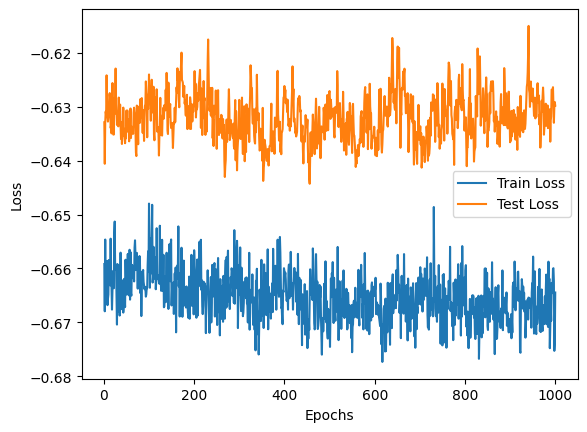

In [33]:
import matplotlib.pyplot as plt

# Número de épocas
epochs = range(1, len(train_loss) + 1)

# Plotar as curvas de loss de treino e teste
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, test_loss, label='Test Loss')

# Adicionar rótulos aos eixos
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Adicionar uma legenda
plt.legend()

# Exibir o gráfico
plt.show()

In [45]:
summary = {
    'model_state':None,
    'nll_history':[],
    'train_loss_history':[]
}


lr = 1e-3
num_epochs = 10
best_loss = 0.0

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_function = nn.NLLLoss()


for e in range(num_epochs):
  print('Epoch:', e)
  cur_loss = epoch(train_datapack, model, optimizer, class_tkns, loss_function)
  test_nll = evaluate(dev_datapack, model, class_tkns, loss_function)

  summary['nll_history'].append(test_nll)
  summary['train_loss_history'].append(cur_loss)

  if test_nll < best_loss:
    summary['model_state'] = model.state_dict()
    best_loss = test_nll

  print('\t Training loss:', cur_loss)
  print('\t Test loss:', test_nll)
  print()

summary_path = 'summary_5.pth'

torch.save(summary, summary_path)

Epoch: 0
	 Training loss: -0.6623320996761322
	 Test loss: -0.6352766553560892

Epoch: 1
	 Training loss: -0.664996725320816
	 Test loss: -0.6363462607065836

Epoch: 2
	 Training loss: -0.6633228898048401
	 Test loss: -0.6325829823811849

Epoch: 3
	 Training loss: -0.663504421710968
	 Test loss: -0.6287752985954285

Epoch: 4
	 Training loss: -0.6656990826129914
	 Test loss: -0.626280685265859

Epoch: 5
	 Training loss: -0.6685850918292999
	 Test loss: -0.6214234828948975

Epoch: 6
	 Training loss: -0.6668850123882294
	 Test loss: -0.6258908112843832

Epoch: 7
	 Training loss: -0.6678331315517425
	 Test loss: -0.6195388038953146

Epoch: 8
	 Training loss: -0.6661926805973053
	 Test loss: -0.6198161840438843

Epoch: 9
	 Training loss: -0.6696873962879181
	 Test loss: -0.6334195733070374



In [30]:
### BEAM SEARCH com beam 2
# input apenas uma frase
def beam_search(model, input, class_tokens):
    model.cuda()
    model.eval()
    end_token = 2

    encoder_inp =  tokenizer(input, return_tensors="pt", padding = True)
    inp_frase = encoder_inp['input_ids']
    inp_mask = encoder_inp['attention_mask'] #Frase e mascara


    idx_token_list = idx2tkn(encoder_inp['input_ids'],class_tokens) #Cria lista de tokens para indices


#Inicializa frases de saida com token de inicio
#Probabilidades como 1
    top_outputs = [torch.Tensor([[0]]).to(torch.int),torch.Tensor([[0]]).to(torch.int)]
    top_scores =[1.0,1.0]

#Primeiro uso do modelo
    probs =  model(inp_frase.to(device), top_outputs[0].to(device), inp_mask.to(device), class_tokens.to(device))
    top2 = torch.topk(probs[0,-1,:],2)

#probabilidades com primeiro token
    top_scores[0] = top2[0][0]
    top_scores[1] = top2[0][1]

#adiciona token na frase
    first_token =  idx_token_list[top2[1][0]]
    second_token =  idx_token_list[top2[1][1]]

    top_outputs[0] = torch.cat((top_outputs[0],first_token.view(1,1)),-1)
    top_outputs[1] = torch.cat((top_outputs[1],second_token.view(1,1)),-1)

#Possivel terminação
    if first_token == end_token:
      return top_outputs[0]

#Booleano que indica se ultimo indice não é de final
    goon_first = True
    if first_token == end_token:
      goon_second = True
    else:
      goon_second = False

#continua beam search
    max_out_tkns = 0
    while(goon_first or goon_second or max_out_tkns > 40):
      l_tkns = []
      l_probs = []

      #explora 3 ou 4 opcoes
      if goon_first:
        first_prob = model(inp_frase.to(device), top_outputs[0].to(device), inp_mask.to(device), class_tokens.to(device))
        top2 = torch.topk(first_prob[0,-1,:],2)


        l_tkns.append(torch.cat((top_outputs[0], idx_token_list[top2[1][0].to('cpu')].view(1,1)),-1))
        l_probs.append(top_scores[0]*top2[0][0])
        l_tkns.append(torch.cat((top_outputs[0], idx_token_list[top2[1][1].to('cpu')].view(1,1)),-1))
        l_probs.append(top_scores[0]*top2[0][1])

      else:
        l_tkns.append(top_outputs[0])
        l_probs.append(top_scores[0])

      if goon_second:
        second_prob = model(inp_frase.to(device), top_outputs[1].to(device), inp_mask.to(device), class_tokens.to(device))
        top2 = torch.topk(second_prob[0,-1,:],2)

        l_tkns.append(torch.cat((top_outputs[1], idx_token_list[top2[1][0].to('cpu')].view(1,1)),-1))
        l_probs.append(top_scores[1]*top2[0][0])
        l_tkns.append(torch.cat((top_outputs[1], idx_token_list[top2[1][1].to('cpu')].view(1,1)),-1))
        l_probs.append(top_scores[1]*top2[0][1])

      else:
        l_tkns.append(top_outputs[1])
        l_probs.append(top_scores[1])


      #seleciona top2
      tensor_scores = torch.Tensor(l_probs)
      tensor_scores = torch.topk(tensor_scores,2)

      top_scores[0] = l_probs[tensor_scores[1][0]]
      top_scores[1] = l_probs[tensor_scores[1][1]]

      top_outputs[0] = l_tkns[tensor_scores[1][0]]
      top_outputs[1] = l_tkns[tensor_scores[1][1]]

      #indica se ambos terminaram
      if top_outputs[0][0][-1] == end_token:
        goon_first = False
      else:
        goon_first = True

      if top_outputs[1][0][-1] == end_token:
        goon_second = False
      else:
        goon_second = True

      max_out_tkns+=1
  #Retorna sequencia com maior probabilidade
    return top_outputs[0]

# Avaliação


In [31]:
path_test = 'test_convert_14res.json'

test_frase, test_tkns, test_pos = load_data(path_test,tokenizer,pol_dict)

In [ ]:
#for a,b,c in train_datapack:
  #frase = a[2]
  #target = b[2]
  #break

In [32]:
def predict(model, frases):

    outputs = []
    for i in range(len(frases)):
        output = beam_search(model, frases[i], class_tkns).tolist()[0]
        outputs.append(output)

    return outputs


In [33]:
outputs = predict(model,test_frase)
outputs[0]

[0, 8084, 8084, 9009, 2]

In [34]:
print(outputs[6])
test_tkns[6]

[0, 41695, 689, 9009, 2]


[0, 2898, 689, 42740, 2]

In [35]:
#F-score = 2*P*R/(P+R)

#Onde:
#P = a + 0.5*b / s
#Onde: a = numero de aspec+emot previstos corretamente
# b = numero de aspec previsto correto mas emocao errada.
# s = numero de aspec+emocao previstos

# R = P = a + 0.5*b / g
# g = numero de aspc+emocao como target

a = 0
b = 0
s = 0
g = 0

for i, label in enumerate(test_tkns):

    aspects_label = []
    aspects_output = []
    for j in range(1,len(label)-1,3):
        asp = [label[j],label[j+1],label[j+2]]
        aspects_label.append(asp)

    for j in range(1,len(outputs[i])-1,3):
        if len(outputs[i])> j+2:
            asp = [outputs[i][j],outputs[i][j+1],outputs[i][j+2]]
            aspects_output.append(asp)

    ##for j in range(len(aspects_ouput)):
    s += len(aspects_output)
    g += len(aspects_label)

    for j in range(len(aspects_output)):
        tk_asp = aspects_output[j][:2]
        if aspects_output[j] in aspects_label:
            a+=1
        elif any(tk_asp == label[:2] for label in aspects_label):
            b+=1


    ##print(f'Target = {aspects_label}')
    ##print(f'Output = {aspects_ouput}')

prec = (a + 0.5*b) / s
rec = (a + 0.5*b) / g
fscore = (2*prec*rec)/(prec+rec)
acc =  (a/s)

print(prec)
print(rec)
print(fscore)
print(acc)



0.46905537459283386
0.34285714285714286
0.3961485557083907
0.21498371335504887


In [36]:
#F-score = 2*P*R/(P+R)

#Onde:
#P = a + 0.5*b / s
#Onde: a = numero de aspec+emot previstos corretamente
# b = numero de aspec previsto correto mas emocao errada.
# s = numero de aspec+emocao previstos

# R = P = a + 0.5*b / g
# g = numero de aspc+emocao como target

a = 0
b = 0
s = 0
g = 0

for i, label in enumerate(test_tkns):

    aspects_label = []
    aspects_output = []
    for j in range(1,len(label)-1,3):
        asp = [label[j],label[j+1]]
        aspects_label.append(asp)

    for j in range(1,len(outputs[i])-1,3):
        if len(outputs[i])> j+2:
            asp = [outputs[i][j],outputs[i][j+1]]
            aspects_output.append(asp)

    ##for j in range(len(aspects_ouput)):
    s += len(aspects_output)
    g += len(aspects_label)

    for j in range(len(aspects_output)):
        tk_asp_inic = aspects_output[j][:0]
        tk_asp_fim = aspects_output[j][:1]
        if aspects_output[j] in aspects_label:
            a+=1
        elif any(tk_asp == label[:0] for label in aspects_label):
            b+=1
        elif any(tk_asp == label[:1] for label in aspects_label):
            b+=1


    ##print(f'Target = {aspects_label}')
    ##print(f'Output = {aspects_ouput}')

prec = (a + 0.5*b) / s
rec = (a + 0.5*b) / g
fscore = (2*prec*rec)/(prec+rec)

print(prec)
print(rec)
print(fscore)




0.7231270358306189
0.5285714285714286
0.6107290233837689


In [37]:
loaded_summary = torch.load('summary.pth')

train_loss_1 = loaded_summary['train_loss_history']
test_loss_1 = loaded_summary['nll_history']

loaded_summary = torch.load('summary_2.pth')

train_loss_2 = loaded_summary['train_loss_history']
test_loss_2 = loaded_summary['nll_history']

loaded_summary = torch.load('summary_3.pth')

train_loss_3 = loaded_summary['train_loss_history']
test_loss_3 = loaded_summary['nll_history']

loaded_summary = torch.load('summary_4.pth')

train_loss_4 = loaded_summary['train_loss_history']
test_loss_4 = loaded_summary['nll_history']

In [38]:
train_loss = train_loss_1 + train_loss_2 + train_loss_3 + train_loss_4
test_loss = test_loss_1 + test_loss_2 + test_loss_3 + test_loss_4

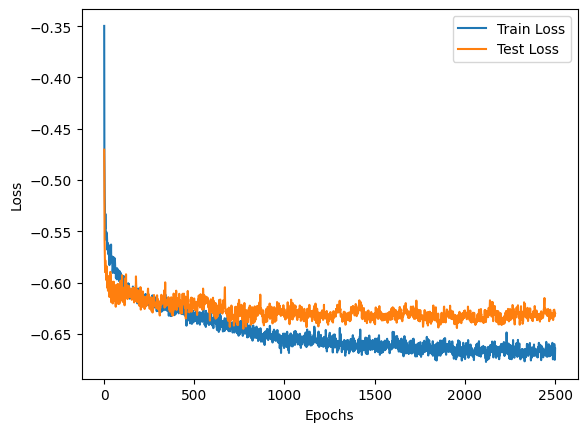

In [39]:
import matplotlib.pyplot as plt

# Número de épocas
epochs = range(1, len(train_loss) + 1)

# Plotar as curvas de loss de treino e teste
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, test_loss, label='Test Loss')

# Adicionar rótulos aos eixos
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Adicionar uma legenda
plt.legend()

# Exibir o gráfico
plt.show()